# TorchVision Instance Segmentation Finetuning Tutorial

이 실습에서는, 우리는 사전학습 된 [Mask R-CNN](https://arxiv.org/abs/1703.06870)과 [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/)을 활용하여 instance segmentation을 진행합니다. 위 데이터셋에는 345개의 보행자 인스턴스가 있는 170개의 이미지가 포함되어 있으며, custom dataset에서 인스턴스 분할 모델을 훈련하기 위한 몇가지 torchvision 기능을 사용하는 방법을 설명하는 데 사용할 것입니다.

먼저 `pycocotools`를 설치해야 합니다. 이 라이브러리는 IoU COCO 메트릭을 계산하는 데 사용됩니다.

In [1]:
%%shell

pip install torch==1.13.1 torchvision==0.14.1

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 68.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu118
    Uninstalling torch-2.1.0+cu118:
      Successfully uninstalled torch-2.1.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu118
    Uninstalling torchvision-0.16.0+cu118:
      Successfully uninstalled torchvision-0.16.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the followi

## Defining the Dataset

[torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) 기능은 새로운 custom dataset을 만들 수 있도록 많은 기능을 제공합니다. 데이터셋 클래스는 표준 `torch.utils.data.Dataset` class 를 상속받아, `__len__` 과 `__getitem__` method를 구현할 수 있습니다.

Dataset은 `__getitem__` 다음과 같은 return값을 가져야 합니다.

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects


라벨에 대한 주의사항이 있다면, 여기서 모델은 클래스 0을 배경으로 간주합니다. 데이터 세트에 배경 클래스가 포함되어 있지 않으면 레이블에 0이 없어야 합니다. 예를 들어 cat과 dog라는 두 개의 클래스만 있다고 가정하면 고양이를 나타내는 1(0이 아님)과 개를 나타내는 2를 정의할 수 있습니다. 예를 들어 이미지 중 하나에 두 클래스가 모두 있는 경우 레이블 텐서는 [1,2]와 같아야 합니다.


### Writing a custom dataset for Penn-Fudan

Penn-Fudan 데이터셋에 대한 custom dataset class을 작성해 봅시다.

먼저 데이터를 다운로드하여 추출해 보겠습니다. (https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip)

In [2]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2023-11-21 08:04:15--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  31.4MB/s    in 1.6s    

2023-11-21 08:04:17 (31.4 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2023-11-21 08:04:17--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-11-21 08:04:17--
Total wall clock time: 2.0s
Downloaded: 1 files, 51M in 1.6s (31.4 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

데이터 세트와 배치 방법을 살펴보겠습니다.

데이터는 다음과 같이 구성됩니다.
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

다음은 해당 인스턴스 분할 마스크가 있는 데이터세트의 이미지 예입니다.

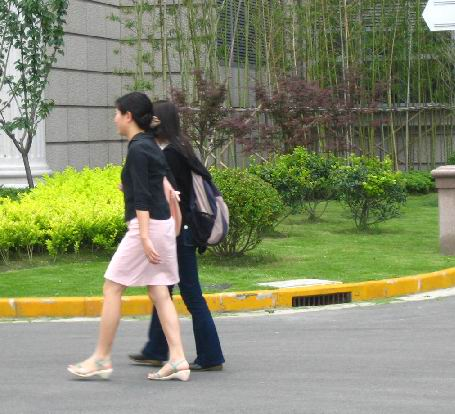

In [3]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00002.png')

<PIL.PngImagePlugin.PngImageFile image mode=L size=559x536 at 0x7C61A6722C50>


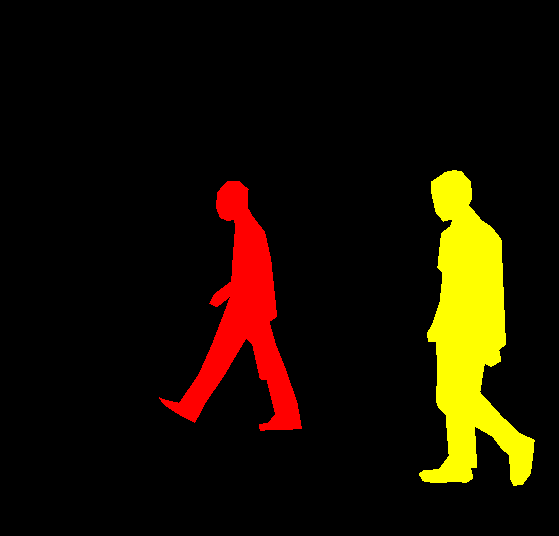

In [8]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
# 각 마스크 인스턴스는 0에서 N까지 서로 다른 색상을 갖습니다.
# 여기서 N은 인스턴스 수입니다.
# 시각화를 쉽게 하기 위해 마스크에 색상 팔레트를 추가해 보겠습니다.
print(mask)
mask.convert('RGB')
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

위와 같이 각 이미지에는 각 색상이 다른 인스턴스에 해당하는 해당 분할 마스크가 있습니다. 이 데이터 세트에 대한 `torch.utils.data.Dataset` 클래스를 작성해 보겠습니다.

2. class PennFudanDataset의 `__getitem__`의 return에 들어있는 masks값들을  instance 별로 각각 시각화하는 코드를 구현하시오. (해당 실습의 custom dataset 샘플 및 이미지 출력 기능을 활용)

In [18]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        # 배경처리를 위해 마스크는 따로 변환하지 않음
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)

        # 각 인스턴스는 다른 색상으로 인코딩됩니다.
        obj_ids = np.unique(mask)

        # 첫 번째 id는 배경이므로 제거
        obj_ids = obj_ids[1:]

        # 색상 인코딩된 마스크를 이진 마스크 세트로 분할
        masks = mask == obj_ids[:, None, None]

        # 각 마스크에 대한 바운딩 박스 좌표 가져오기
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # 보행자 클래스만 있는 데이터셋
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # instance가 바글바글한 데이터가 아니라고 가정 (전부 0)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # data augmentation
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [29]:
dataset[0][1]['masks'].shape

torch.Size([2, 536, 559])

이것이 데이터 세트의 전부입니다. 이 데이터세트에 대한 출력이 어떻게 구성되어 있는지 살펴보겠습니다.

In [26]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

따라서 기본적으로 dataset는 `PIL.Image`와 `boxes`, `labels` 및 `masks`를 포함한 여러 필드를 포함하는 dictionary를 반환한다는 것을 알 수 있습니다.

## Defining your model

이 튜토리얼에서는 Faster R-CNN을 기반으로 하는 Mask R-CNN을 사용할 것입니다. Faster R-CNN은 이미지의 잠재적 개체에 대한 bounding box와 클래스 점수를 모두 예측하는 모델입니다. Mask R-CNN은 Faster R-CNN에 추가 분기를 추가하여 각 인스턴스에 대한 세분화 마스크도 예측합니다.


Torchvision modelzoo에서 사용 가능한 모델 중 하나를 수정하려는 두 가지 일반적인 상황이 있습니다. 첫 번째는 사전 훈련된 모델에서 시작하여 마지막 레이어를 fine-tuning하려는 경우입니다. 그리고 다른 한 방법은 모델의 백본을 다른 백본으로 교체하려는 경우입니다. 예를 들어, 현재 기본 백본(ResNet-50)이 일부 애플리케이션에는 너무 클 수 있으며 더 작은 모델이 필요할 수 있습니다.




### An Instance segmentation model for PennFudan Dataset

우리의 경우 데이터 세트가 매우 작기 때문에 사전 훈련된 모델을 기반으로 fine-tuning을 진행하는것이 합리적으로 보입니다. 여기서 우리는 인스턴스 분할 마스크도 계산하기를 원하므로 Mask R-CNN을 사용할 것입니다.

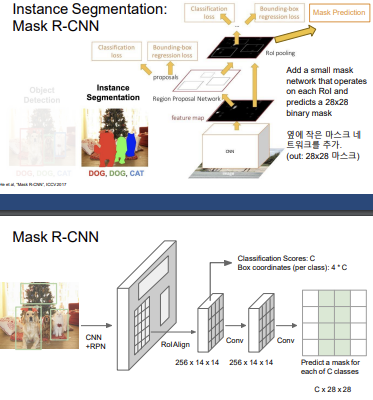

In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes):

    # instance segmentation (pre-trained on COCO) 모델 로딩
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # 로딩한 모델의 마지막 분류모델의 input feature수 얻기
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # 미리 학습된 헤더를 새로운 것으로 바꿉니다
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # 마스크 분류기를 위한 입력 특징들의 차원을 얻습니다
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # 마스크 예측기를 새로운 것으로 바꿉니다
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


## Training and evaluation functions

'references/detection/'에는 탐지 모델의 학습 및 평가를 단순화하는 여러 가지 헬퍼 함수가 있습니다.
여기서 우리는 다음 기능들을 가져와 사용할 것 입니다: `references/detection/engine.py`, `references/detection/utils.py`, `references/detection/transforms.py`. 다음 github 링크에 들어가면 해당 소스코드를 확인할 수 있습니다. (https://github.com/pytorch/vision/tree/main/references/detection)





Colab에서도 사용할 수 있도록 여기에 해당 파일(및 해당 종속성)을 복사해 보겠습니다.

In [12]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 431083, done.
remote: Counting objects: 100% (11545/11545), done.
remote: Compressing objects: 100% (655/655), done.
remote: Total 431083 (delta 10896), reused 11486 (delta 10873), pack-reused 419538
Receiving objects: 100% (431083/431083), 853.23 MiB | 25.36 MiB/s, done.
Resolving deltas: 100% (399976/399976), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)



Data augmentation / transformation 기능을 구현하기 위해서는 이미지 뿐 아니라 해당 instance가 표시된 마스크 및 bounding box정보들 또한 변환되어야 합니다. 해당 기능을 간단히 구현하기 위해서 위에서 다운로드한 함수들을 사용합니다: `refereces/detection`


In [13]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# data augmentation을 위하 transform 함수
def get_transform(train):
    transforms = []
    # 이미지를 PyTorch Tensor로 변환합니다.
    transforms.append(T.ToTensor())
    if train:
        # training인 경우 이미지와 정답mask를 둘다 무작위로 뒤집습니다.
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Testing forward() method

데이터셋을 학습하기전에, DataLoader 클래스를 구성하고 샘플데이터를 한개 가져와서 돌려봅시다.

In [14]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn
)

# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

### Putting everything together

이제 우리는 Dataset 클래스, DataLoader과 data transform, 모델을 모두 갖게 되었습니다. 모두 한번에 합쳐서 학습을 진행해 봅시다.

In [15]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


모델과 optimizer도 모두 구성해봅시다.

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

이제 매 epoch마다 평가하면서 10개의 epoch에 대해 모델을 훈련해 보겠습니다. `train_one_epoch()`과 `evaluate()` 함수의 디테일은 다음 오픈소스 링크에서 확인할 수 있습니다. (https://github.com/pytorch/vision/blob/main/references/detection/engine.py)


In [17]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:08:29  lr: 0.000090  loss: 2.7900 (2.7900)  loss_classifier: 0.7402 (0.7402)  loss_box_reg: 0.3405 (0.3405)  loss_mask: 1.6637 (1.6637)  loss_objectness: 0.0430 (0.0430)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 8.4881  data: 0.8214  max mem: 2162
Epoch: [0]  [10/60]  eta: 0:01:04  lr: 0.000936  loss: 1.3960 (1.7271)  loss_classifier: 0.5142 (0.4827)  loss_box_reg: 0.2960 (0.2981)  loss_mask: 0.7157 (0.9198)  loss_objectness: 0.0169 (0.0217)  loss_rpn_box_reg: 0.0045 (0.0048)  time: 1.2853  data: 0.0838  max mem: 3315
Epoch: [0]  [20/60]  eta: 0:00:36  lr: 0.001783  loss: 0.9983 (1.2310)  loss_classifier: 0.2241 (0.3362)  loss_box_reg: 0.2910 (0.2870)  loss_mask: 0.3238 (0.5871)  loss_objectness: 0.0109 (0.0162)  loss_rpn_box_reg: 0.0042 (0.0045)  time: 0.5465  data: 0.0114  max mem: 3315
Epoch: [0]  [30/60]  eta: 0:00:24  lr: 0.002629  loss: 0.5575 (1.0156)  loss_classifier: 0.0996 (0.2555)  loss_box_reg: 0.2602 (0.2867)  loss_mask: 0.1827 (0.4533)  loss_ob

이제 훈련이 완료되었으므로 테스트 이미지에서 실제로 예측하는 내용을 살펴보겠습니다.

In [39]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

예측결과를 print하면 여기에 dictionary가 있음을 알 수 있습니다.
Dictionary에는 우리가 입력으로 준 이미지에 대한 예측값이 포함되어 있습니다. 이 경우 `boxes`, `labels`, `masks` 및 `scores`가 필드로 포함되어 있음을 확인할 수 있습니다.

In [40]:
prediction

[{'boxes': tensor([[ 63.2886,  42.8938, 189.8943, 325.2939],
          [276.5996,  22.4354, 290.9745,  75.8749],
          [ 83.8550,  33.2285, 188.8388, 198.5966],
          [284.1135,  22.6040, 290.9138,  77.0541]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9943, 0.9332, 0.3834, 0.1537], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
           

이미지와 예측된 분할 마스크를 살펴보겠습니다.

이를 위해 픽셀값은 0-1 범위로 조정되야하고, 데이터의 차원 역시 `[C, H, W]` 형식으로 변환해야 합니다.

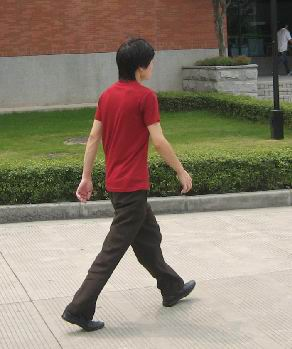

In [41]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

이제 예측 segmentation 마스크를 시각화해 보겠습니다. 마스크는 '[N, 1, H, W]' 형태로 예측되며, 여기서 'N'은 예측 횟수입니다. 데이터의 값은 0-1 사이의 확률 로 표현된 확률맵의 형태를 갖습니다.

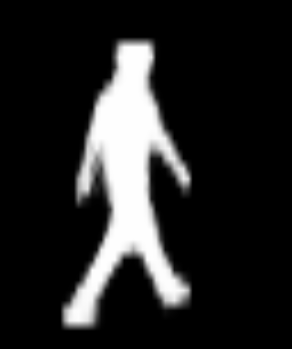

In [42]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

본 실습에서는 사용자 지정 데이터셋을 기반으로 인스턴스 세분화 모델에 대한 학습 파이프라인을 만드는 방법을 배웠습니다. 이를 위해 이미지와 정답 상자 및 분할 마스크를 반환하는 `torch.utils.data.Dataset` 클래스를 작성했습니다. 또한 이 새로운 데이터셋을 기반으로 전이 학습을 수행하기 위해 COCO train2017에서 사전 훈련된 Mask R-CNN 모델을 활용했습니다. 해당 문제에 대한 구체적인 예를 보려면 [torchvision GitHub repo](https://github.com/pytorch/vision)에 있는 `references/detection/train.py`를 확인하세요.


## 실습 퀴즈

위 실습 코드를 모두 공부한 후 다음 질문에 답하시오.

1. Instance segmentation이 semantic segmentation 및 object detection과 다른점에 대하여 서술하시오.  

2. class PennFudanDataset의 `__getitem__`의 return에 들어있는 masks값들을  instance 별로 각각 시각화하는 코드를 구현하시오. (해당 실습의 custom dataset 샘플 및 이미지 출력 기능을 활용)

3. 학습 매 epoch마다 샘플 이미지의 예측된 mask를 출력하도록 코드를 작성하시오. Pretrained되지 않은 MaskRCNN 모델을 이용할 것. (학습은 총 10epoch진행)

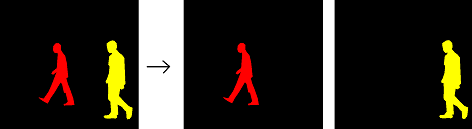



1. Object detection은 객체의 위치와 클래스만을 식별하며, 객체의 정확한 형태나 경계를 파악하지 않는다
2. Semantic segmentation은 이미지 내 모든 객체의 정확한 형태와 경계를 파악하지만, 개별 객체간의 구분은 하지 않는다.
3. Instance segmentation은 semantic segmentation과 달리 동일한 클래스에 속하는 서로 다른 객체들을 개별적으로 구분한다. 그리고 object detection과 달리 객체의 정확한 형태와 경계를 파악한다.

In [44]:
dataset[0][1]['masks'].shape

torch.Size([2, 536, 559])

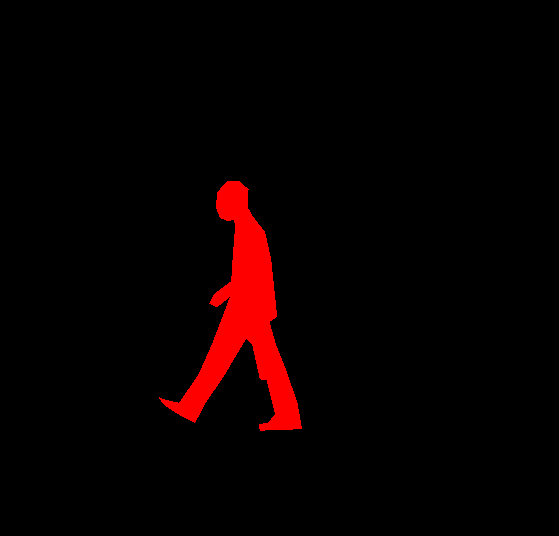

In [35]:
dataset = PennFudanDataset('PennFudanPed/')
mask = dataset[0][1]['masks'][0]

img_mask = Image.fromarray(mask.mul(255).byte().cpu().numpy())

img_mask.convert('P')

img_mask.putpalette([
    0, 0, 0,
    255, 0, 0,
    255, 255, 0,
    255,0,0
])

img_mask

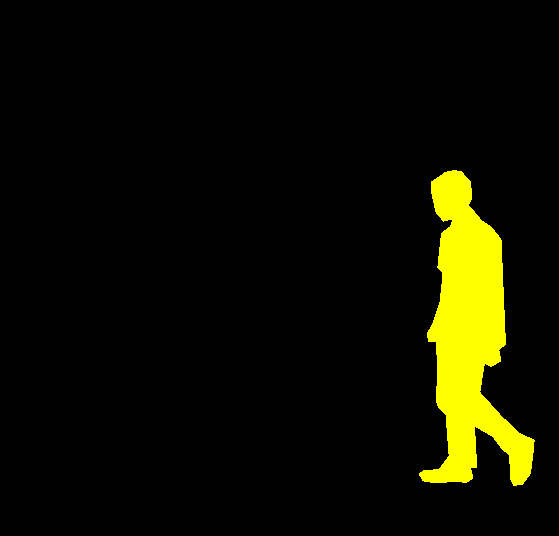

In [37]:
dataset = PennFudanDataset('PennFudanPed/')
mask = dataset[0][1]['masks'][1]
img_mask = Image.fromarray(mask.mul(255).byte().cpu().numpy())

img_mask.convert('P')

img_mask.putpalette([
    0, 0, 0,
    255, 0, 0,
    255, 255, 0,
    255,255,0
])

img_mask

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: [0]  [ 0/60]  eta: 0:01:15  lr: 0.000090  loss: 0.4564 (0.4564)  loss_classifier: 0.0728 (0.0728)  loss_box_reg: 0.1627 (0.1627)  loss_mask: 0.2001 (0.2001)  loss_objectness: 0.0031 (0.0031)  loss_rpn_box_reg: 0.0177 (0.0177)  time: 1.2516  data: 0.5783  max mem: 3315
Epoch: [0]  [10/60]  eta: 0:00:30  lr: 0.000936  loss: 0.2530 (0.3062)  loss_classifier: 0.0378 (0.0382)  loss_box_reg: 0.0843 (0.1080)  loss_mask: 0.1542 (0.1493)  loss_objectness: 0.0033 (0.0046)  loss_rpn_box_reg: 0.0051 (0.0061)  time: 0.6062  data: 0.0619  max mem: 3315
Epoch: [0]  [20/60]  eta: 0:00:24  lr: 0.001783  loss: 0.2530 (0.2947)  loss_classifier: 0.0355 (0.0373)  loss_box_reg: 0.0803 (0.1018)  loss_mask: 0.1337 (0.1462)  loss_objectness: 0.0016 (0.0035)  loss_rpn_box_reg: 0.0051 (0.0059)  time: 0.5675  data: 0.0123  max mem: 3359
Epoch: [0]  [30/60]  eta: 0:00:17  lr: 0.002629  loss: 0.2863 (0.3062)  loss_classifier: 0.0388 (0.0415)  loss_box_reg: 0.0815 (0.1077)  loss_mask: 0.1358 (0.1481)  loss_ob

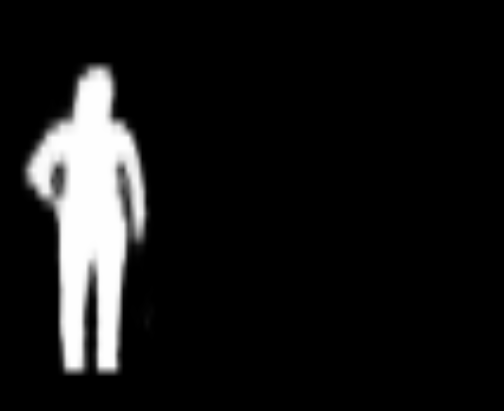

Epoch: [1]  [ 0/60]  eta: 0:01:00  lr: 0.005000  loss: 0.2718 (0.2718)  loss_classifier: 0.0247 (0.0247)  loss_box_reg: 0.0568 (0.0568)  loss_mask: 0.1832 (0.1832)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0067 (0.0067)  time: 1.0121  data: 0.4551  max mem: 3359
Epoch: [1]  [10/60]  eta: 0:00:31  lr: 0.005000  loss: 0.2378 (0.2559)  loss_classifier: 0.0250 (0.0309)  loss_box_reg: 0.0636 (0.0811)  loss_mask: 0.1316 (0.1382)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0039 (0.0051)  time: 0.6361  data: 0.0512  max mem: 3370
Epoch: [1]  [20/60]  eta: 0:00:24  lr: 0.005000  loss: 0.2320 (0.2649)  loss_classifier: 0.0282 (0.0370)  loss_box_reg: 0.0644 (0.0822)  loss_mask: 0.1316 (0.1398)  loss_objectness: 0.0004 (0.0014)  loss_rpn_box_reg: 0.0034 (0.0045)  time: 0.6005  data: 0.0123  max mem: 3370
Epoch: [1]  [30/60]  eta: 0:00:18  lr: 0.005000  loss: 0.2308 (0.2529)  loss_classifier: 0.0411 (0.0375)  loss_box_reg: 0.0664 (0.0756)  loss_mask: 0.1188 (0.1340)  loss_ob

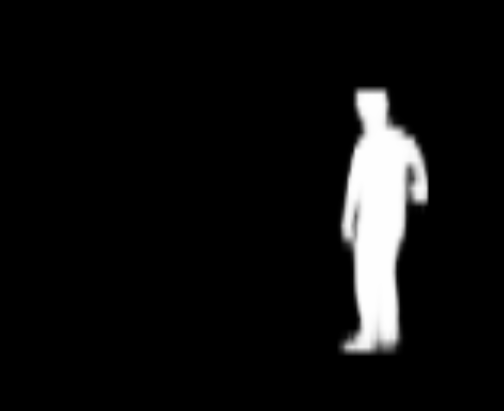

Epoch: [2]  [ 0/60]  eta: 0:01:04  lr: 0.000500  loss: 0.1758 (0.1758)  loss_classifier: 0.0234 (0.0234)  loss_box_reg: 0.0400 (0.0400)  loss_mask: 0.1074 (0.1074)  loss_objectness: 0.0023 (0.0023)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 1.0780  data: 0.5059  max mem: 3644
Epoch: [2]  [10/60]  eta: 0:00:31  lr: 0.000500  loss: 0.1969 (0.2149)  loss_classifier: 0.0249 (0.0303)  loss_box_reg: 0.0477 (0.0485)  loss_mask: 0.1181 (0.1298)  loss_objectness: 0.0011 (0.0028)  loss_rpn_box_reg: 0.0028 (0.0036)  time: 0.6248  data: 0.0537  max mem: 3644
Epoch: [2]  [20/60]  eta: 0:00:24  lr: 0.000500  loss: 0.1925 (0.2011)  loss_classifier: 0.0249 (0.0273)  loss_box_reg: 0.0444 (0.0441)  loss_mask: 0.1181 (0.1245)  loss_objectness: 0.0009 (0.0018)  loss_rpn_box_reg: 0.0025 (0.0035)  time: 0.5853  data: 0.0115  max mem: 3644
Epoch: [2]  [30/60]  eta: 0:00:18  lr: 0.000500  loss: 0.1806 (0.2073)  loss_classifier: 0.0250 (0.0281)  loss_box_reg: 0.0354 (0.0476)  loss_mask: 0.1111 (0.1259)  loss_ob

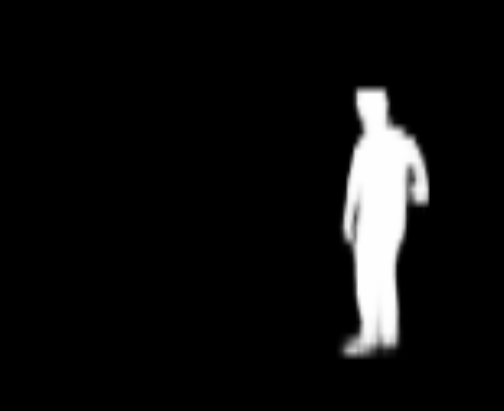

Epoch: [3]  [ 0/60]  eta: 0:01:05  lr: 0.000500  loss: 0.1397 (0.1397)  loss_classifier: 0.0157 (0.0157)  loss_box_reg: 0.0289 (0.0289)  loss_mask: 0.0939 (0.0939)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 1.0936  data: 0.5286  max mem: 3644
Epoch: [3]  [10/60]  eta: 0:00:33  lr: 0.000500  loss: 0.1943 (0.2172)  loss_classifier: 0.0295 (0.0341)  loss_box_reg: 0.0426 (0.0507)  loss_mask: 0.1269 (0.1280)  loss_objectness: 0.0006 (0.0009)  loss_rpn_box_reg: 0.0028 (0.0035)  time: 0.6651  data: 0.0548  max mem: 3644
Epoch: [3]  [20/60]  eta: 0:00:25  lr: 0.000500  loss: 0.1853 (0.2052)  loss_classifier: 0.0241 (0.0305)  loss_box_reg: 0.0426 (0.0470)  loss_mask: 0.1055 (0.1237)  loss_objectness: 0.0006 (0.0008)  loss_rpn_box_reg: 0.0028 (0.0031)  time: 0.6191  data: 0.0101  max mem: 3644
Epoch: [3]  [30/60]  eta: 0:00:18  lr: 0.000500  loss: 0.1559 (0.1949)  loss_classifier: 0.0212 (0.0289)  loss_box_reg: 0.0256 (0.0425)  loss_mask: 0.1029 (0.1196)  loss_ob

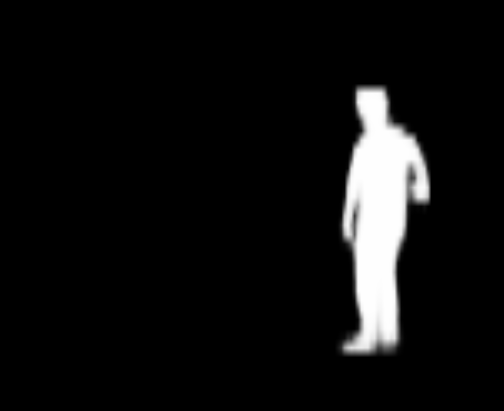

Epoch: [4]  [ 0/60]  eta: 0:00:59  lr: 0.000500  loss: 0.1710 (0.1710)  loss_classifier: 0.0138 (0.0138)  loss_box_reg: 0.0259 (0.0259)  loss_mask: 0.1269 (0.1269)  loss_objectness: 0.0014 (0.0014)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 0.9842  data: 0.4478  max mem: 3644
Epoch: [4]  [10/60]  eta: 0:00:30  lr: 0.000500  loss: 0.1630 (0.1775)  loss_classifier: 0.0204 (0.0214)  loss_box_reg: 0.0259 (0.0321)  loss_mask: 0.1062 (0.1207)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0023 (0.0026)  time: 0.6170  data: 0.0486  max mem: 3644
Epoch: [4]  [20/60]  eta: 0:00:23  lr: 0.000500  loss: 0.1682 (0.1901)  loss_classifier: 0.0229 (0.0265)  loss_box_reg: 0.0310 (0.0377)  loss_mask: 0.1103 (0.1219)  loss_objectness: 0.0004 (0.0011)  loss_rpn_box_reg: 0.0023 (0.0030)  time: 0.5800  data: 0.0107  max mem: 3644
Epoch: [4]  [30/60]  eta: 0:00:18  lr: 0.000500  loss: 0.1751 (0.1905)  loss_classifier: 0.0295 (0.0279)  loss_box_reg: 0.0345 (0.0399)  loss_mask: 0.1084 (0.1188)  loss_ob

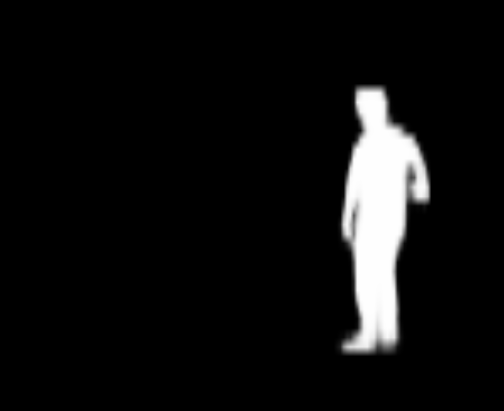

Epoch: [5]  [ 0/60]  eta: 0:01:03  lr: 0.000050  loss: 0.2059 (0.2059)  loss_classifier: 0.0379 (0.0379)  loss_box_reg: 0.0428 (0.0428)  loss_mask: 0.1234 (0.1234)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 1.0521  data: 0.4835  max mem: 3644
Epoch: [5]  [10/60]  eta: 0:00:32  lr: 0.000050  loss: 0.1732 (0.1830)  loss_classifier: 0.0230 (0.0253)  loss_box_reg: 0.0357 (0.0420)  loss_mask: 0.1098 (0.1132)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0020 (0.0019)  time: 0.6429  data: 0.0523  max mem: 3644
Epoch: [5]  [20/60]  eta: 0:00:24  lr: 0.000050  loss: 0.1608 (0.1711)  loss_classifier: 0.0210 (0.0238)  loss_box_reg: 0.0323 (0.0363)  loss_mask: 0.1005 (0.1086)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0020 (0.0019)  time: 0.5914  data: 0.0112  max mem: 3644
Epoch: [5]  [30/60]  eta: 0:00:18  lr: 0.000050  loss: 0.1655 (0.1741)  loss_classifier: 0.0242 (0.0245)  loss_box_reg: 0.0354 (0.0367)  loss_mask: 0.1104 (0.1103)  loss_ob

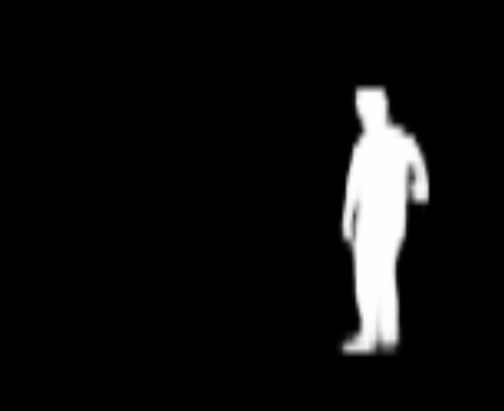

Epoch: [6]  [ 0/60]  eta: 0:01:05  lr: 0.000050  loss: 0.1914 (0.1914)  loss_classifier: 0.0346 (0.0346)  loss_box_reg: 0.0401 (0.0401)  loss_mask: 0.1121 (0.1121)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0045 (0.0045)  time: 1.0834  data: 0.4770  max mem: 3644
Epoch: [6]  [10/60]  eta: 0:00:31  lr: 0.000050  loss: 0.2067 (0.2016)  loss_classifier: 0.0300 (0.0288)  loss_box_reg: 0.0401 (0.0401)  loss_mask: 0.1145 (0.1285)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0030 (0.0035)  time: 0.6233  data: 0.0632  max mem: 3644
Epoch: [6]  [20/60]  eta: 0:00:24  lr: 0.000050  loss: 0.1698 (0.1833)  loss_classifier: 0.0190 (0.0270)  loss_box_reg: 0.0237 (0.0356)  loss_mask: 0.1059 (0.1174)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0020 (0.0027)  time: 0.5938  data: 0.0174  max mem: 3644
Epoch: [6]  [30/60]  eta: 0:00:18  lr: 0.000050  loss: 0.1698 (0.1793)  loss_classifier: 0.0226 (0.0263)  loss_box_reg: 0.0338 (0.0352)  loss_mask: 0.1033 (0.1146)  loss_ob

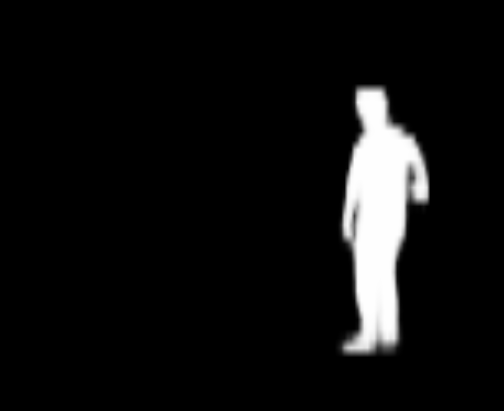

Epoch: [7]  [ 0/60]  eta: 0:01:23  lr: 0.000050  loss: 0.1526 (0.1526)  loss_classifier: 0.0201 (0.0201)  loss_box_reg: 0.0205 (0.0205)  loss_mask: 0.1058 (0.1058)  loss_objectness: 0.0052 (0.0052)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 1.3850  data: 0.7774  max mem: 3644
Epoch: [7]  [10/60]  eta: 0:00:32  lr: 0.000050  loss: 0.2015 (0.1966)  loss_classifier: 0.0305 (0.0290)  loss_box_reg: 0.0406 (0.0415)  loss_mask: 0.1171 (0.1218)  loss_objectness: 0.0006 (0.0013)  loss_rpn_box_reg: 0.0016 (0.0031)  time: 0.6561  data: 0.0789  max mem: 3644
Epoch: [7]  [20/60]  eta: 0:00:24  lr: 0.000050  loss: 0.1828 (0.1972)  loss_classifier: 0.0260 (0.0295)  loss_box_reg: 0.0385 (0.0423)  loss_mask: 0.1171 (0.1215)  loss_objectness: 0.0006 (0.0010)  loss_rpn_box_reg: 0.0021 (0.0030)  time: 0.5801  data: 0.0100  max mem: 3644
Epoch: [7]  [30/60]  eta: 0:00:18  lr: 0.000050  loss: 0.1703 (0.1938)  loss_classifier: 0.0241 (0.0286)  loss_box_reg: 0.0263 (0.0422)  loss_mask: 0.1081 (0.1192)  loss_ob

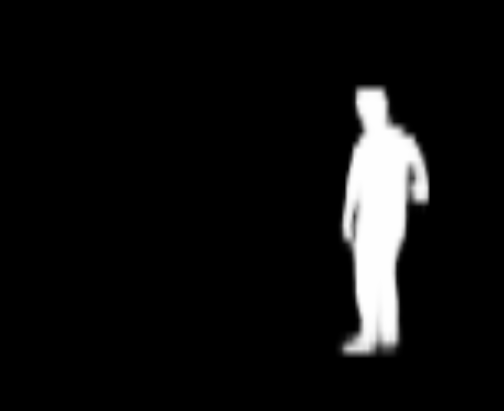

Epoch: [8]  [ 0/60]  eta: 0:01:38  lr: 0.000005  loss: 0.2058 (0.2058)  loss_classifier: 0.0276 (0.0276)  loss_box_reg: 0.0477 (0.0477)  loss_mask: 0.1279 (0.1279)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0023 (0.0023)  time: 1.6376  data: 0.9114  max mem: 3644
Epoch: [8]  [10/60]  eta: 0:00:34  lr: 0.000005  loss: 0.2058 (0.1975)  loss_classifier: 0.0248 (0.0283)  loss_box_reg: 0.0477 (0.0480)  loss_mask: 0.1279 (0.1182)  loss_objectness: 0.0002 (0.0004)  loss_rpn_box_reg: 0.0024 (0.0026)  time: 0.6923  data: 0.0894  max mem: 3644
Epoch: [8]  [20/60]  eta: 0:00:25  lr: 0.000005  loss: 0.1867 (0.2042)  loss_classifier: 0.0248 (0.0292)  loss_box_reg: 0.0393 (0.0466)  loss_mask: 0.1152 (0.1248)  loss_objectness: 0.0002 (0.0007)  loss_rpn_box_reg: 0.0024 (0.0028)  time: 0.5973  data: 0.0097  max mem: 3644
Epoch: [8]  [30/60]  eta: 0:00:19  lr: 0.000005  loss: 0.1812 (0.2014)  loss_classifier: 0.0289 (0.0292)  loss_box_reg: 0.0393 (0.0457)  loss_mask: 0.1152 (0.1229)  loss_ob

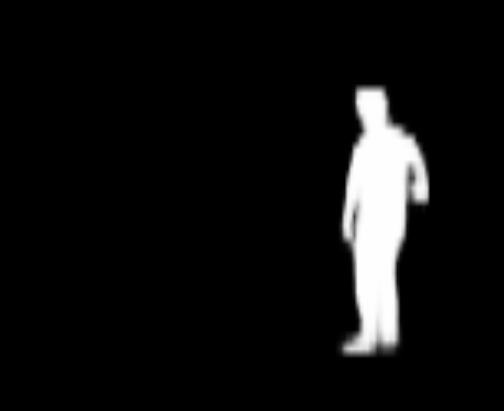

Epoch: [9]  [ 0/60]  eta: 0:01:27  lr: 0.000005  loss: 0.2011 (0.2011)  loss_classifier: 0.0292 (0.0292)  loss_box_reg: 0.0364 (0.0364)  loss_mask: 0.1319 (0.1319)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0034 (0.0034)  time: 1.4552  data: 0.6618  max mem: 3804
Epoch: [9]  [10/60]  eta: 0:00:35  lr: 0.000005  loss: 0.2011 (0.2090)  loss_classifier: 0.0298 (0.0337)  loss_box_reg: 0.0364 (0.0492)  loss_mask: 0.1178 (0.1210)  loss_objectness: 0.0006 (0.0012)  loss_rpn_box_reg: 0.0042 (0.0039)  time: 0.7085  data: 0.0686  max mem: 3804
Epoch: [9]  [20/60]  eta: 0:00:25  lr: 0.000005  loss: 0.1616 (0.1908)  loss_classifier: 0.0217 (0.0283)  loss_box_reg: 0.0314 (0.0406)  loss_mask: 0.1048 (0.1176)  loss_objectness: 0.0005 (0.0010)  loss_rpn_box_reg: 0.0023 (0.0032)  time: 0.5967  data: 0.0105  max mem: 3804
Epoch: [9]  [30/60]  eta: 0:00:19  lr: 0.000005  loss: 0.1614 (0.1932)  loss_classifier: 0.0215 (0.0282)  loss_box_reg: 0.0262 (0.0417)  loss_mask: 0.1048 (0.1193)  loss_ob

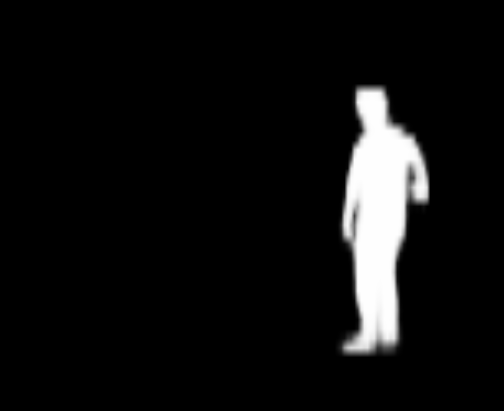

In [43]:
from torch.optim.lr_scheduler import StepLR
num_epochs = 10
img , _ = dataset_test[10]

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

    prediction = model([img.to(device)])
    img2 = Image.fromarray(prediction[0]['masks'][0,0].mul(255).byte().cpu().numpy())
    display(img2)